<div align="center">

# CMIP6 Climate projections. Evaluating uncertainty in projected changes in extreme temperature indices for the reinsurance sector. 

## Use case: Defining a strategy to optimise reinsurance protections  

</div>

## Quality assessment question
* **What are the associated uncertainties and projected future changes in air temperature extremes in Europe?**

</br>

Production date: 24-05-2024

Produced by: CMCC foundation - Euro-Mediterranean Center on Climate Change. Albert Martinez Boti.



Climate change has a major impact on the reinsurance market [[1]](https://doi.org/10.3390/atmos11020146)[[2]](https://doi.org/10.5194/nhess-22-659-2022). In the third assessment report of the IPCC, hot temperature extremes were already presented as relevant to insurance and related services [[3]](https://www.ipcc.ch/site/assets/uploads/2018/03/wg2TARchap8.pdf). Consequently, the need for reliable regional and global climate projections has become paramount, offering valuable insights for optimizing reinsurance strategies in the face of a changing climate landscape. Nonetheless, despite their pivotal role, uncertainties inherent in these projections can potentially lead to misuse [[4]](https://doi.org/10.1002/wcc.71)[[5]](https://doi.org/10.1002/wcc.579). This underscores the importance of accurately calculating and accounting for uncertainties to ensure their appropriate consideration. This notebook utilizes data from a subset of models from [CMIP6](https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cmip6?tab=overview) Global Climate Models (GCMs) and explores the uncertainty in future projections of maximum temperature-based extreme indices by considering the ensemble inter-model spread of projected changes. Two maximum temperature-based indices from [ECA&D](https://www.ecad.eu/indicesextremes/) indices (one of physical nature and the other of statistical nature) are computed using the [icclim](https://icclim.readthedocs.io/en/stable/) Python package. The first index, identified by the ETCCDI short name 'SU', quantifies the occurrence of summer days (i.e., with daily maximum temperatures exceeding 25°C) within a year or a season (JJA in this notebook). The second index, labeled 'TX90p', describes the number of days with daily maximum temperatures exceeding the daily 90th percentile of maximum temperature for a 5-day moving window. For this notebook, the daily 90th percentile threshold is calculated for the historical period spanning from 1971 to 2000. The index calculations, though, are performed over the future period from 2015 to 2099, following the Shared Socioeconomic Pathways SSP5-8.5. It is important to note that the results presented here pertain to a specific subset of the CMIP6 ensemble and may not be generalizable to the entire dataset.

## Quality assessment statement

* Looking ahead to future projections (2015-2099), all models within the subset agree on projecting general positive trends for both indices across Europe during the temporal aggregation of JJA, with a particularly notable positive projected trend in the Mediterranean Basin for 'TX90p'. This finding is consistent with the results of Josep Cos et al. (2022) [[6]](https://doi.org/10.5194/esd-13-321-2022), who evaluated the Mediterranean climate change hotspot using CMIP6 projections.

* While certain regions exhibit near-zero trends for the 'SU' index, possibly due to threshold temperature constraints, others show higher values, highlighting the importance of considering both statistically and physically based extreme indices for comprehensive assessments.

* Utilizing CMIP6 projections presents a valuable opportunity to anticipate future trends in air temperature extremes across Europe, enabling the insurance industry to refine risk management strategies.


<div>
    <img src="trend_future_TX90p.png" alt="Future trend TX90p" width="900">
    <div style="max-width: 900px;">
    <p><strong>Fig A.</strong> Number of days with daily maximum temperatures exceeding the daily 90th percentile of maximum temperature for a 5-day moving window ('TX90p') for the temporal aggregation of 'JJA'. Trend for the future period (2015-2099). For this index, the reference daily 90th percentile threshold is calculated based on the historical period (1971-2000). The layout includes data corresponding to: (a) the ensemble median (understood as the median of the trend values of the chosen subset of models calculated for each grid cell) and (b) the ensemble spread (derived as the standard deviation of the distribution of the chosen subset of models).</p>
</div>

# Methodology

This notebook offers an assessment of the projected changes and their associated uncertainties using a subset of 16 models from [CMIP6](https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cmip6?tab=overview). The uncertainty is examined by analyzing the ensemble inter-model spread of projected changes for the maximum-temperature-based indices 'SU' and 'TX90p,' calculated over the temporal aggregation of JJA for the future period spanning from 2015 to 2099. In particular, spatial patterns of climate projected trends are examined and displayed for each model individually and for the ensemble median (calculated for each grid cell), alongside the ensemble inter-model spread to account for projected uncertainty. Additionally, spatially-averaged trend values are analyzed and presented using box plots to provide an overview of trend behavior across the distribution of the chosen subset of models when averaged across Europe.

The analysis and results follow the next outline:

**1. [Parameters, requests and functions definition](#1.-Parameters,-requests-and-functions-definition):**
 * [1.1. Import packages](#1.1.-Import-packages)
 * [1.2. Define Parameters](#1.2.-Define-Parameters)
 * [1.3. Define models](#1.3.-Define-models)
 * [1.4. Define land-sea mask request](#1.4.-Define-land-sea-mask-request)
 * [1.5. Define model requests](#1.5.-Define-model-requests)
 * [1.6. Functions to cache](#1.6.-Functions-to-cache)

**2. [Downloading and processing](#2.-Downloading-and-processing):**
 * [2.1. Download and transform the regridding model](#2.1.-Download-and-transform-the-regridding-model)
 * [2.2. Download and transform models](#2.2.-Download-and-transform-models)
 * [2.3. Apply land-sea mask and change attributes](#2.3.-Apply-land-sea-mask,-change-attributes-and-cut-the-region-to-show)

**3. [Plot and describe results](#3.-Plot-and-describe-results)**:
 *  [3.1. Define plotting functions](#3.1.-Define-plotting-functions)
 *  [3.2. Plot ensemble maps](#3.2.-Plot-ensemble-maps)
 *  [3.3. Plot model maps](#3.3.-Plot-model-maps)
 *  [3.4. Boxplots of the future trend](#3.4.-Boxplots-of-the-future-trend)
 *  [3.5. Results summary and discussion](#3.5.-Results-summary-and-discussion)


# Analysis and results

## 1. Parameters, requests and functions definition

### 1.1. Import packages

In [1]:
import math
import tempfile
import warnings
import textwrap
warnings.filterwarnings("ignore")

import cartopy.crs as ccrs
import icclim
import matplotlib.pyplot as plt
import xarray as xr
from c3s_eqc_automatic_quality_control import diagnostics, download, plot, utils
from xarrayMannKendall import Mann_Kendall_test

plt.style.use("seaborn-v0_8-notebook")
plt.rcParams["hatch.linewidth"] = 0.5

### 1.2. Define Parameters

In the "Define Parameters" section, various customizable options for the notebook are specified. Most of the parameters chosen are the same to those chosen for the [Use  Case 1 - Quality Assessment Question 1](), being them:
- The initial and ending year used for the future projections period can be specified by changing the parametes `future_slice` (2015-2099 is chosen for consistency between CORDEX and CMIP6).
- `historical_slice` determines the historical period used (1971 to 2000 is choosen to allow comparison to CORDEX models in other assessments).
- The `timeseries` set the temporal aggregation. For instance, selecting "JJA" implies considering only the JJA season.
- `collection_id` provides the choice between Global Climate Models CMIP6 or Regional Climate Models CORDEX.
- `area` allows specifying the geographical domain of interest.
- The `interpolation_method` parameter allows selecting the interpolation method when regridding is performed over the indices.
- The `chunk` selection allows the user to define if dividing into chunks when downloading the data on their local machine. Although it does not significantly affect the analysis, it is recommended to keep the default value for optimal performance.

In [2]:
# Time period
historical_slice = slice(1971, 2000)
future_slice = slice(2015, 2099)
assert future_slice.start > historical_slice.stop

# Choose annual or seasonal timeseries
timeseries = "JJA"
assert timeseries in ("annual", "DJF", "MAM", "JJA", "SON")

# Variable
variable = "temperature"
assert variable in ("temperature", "precipitation")

# Choose CORDEX or CMIP6
collection_id = "CMIP6"
assert collection_id in ("CORDEX", "CMIP6")

# Interpolation method
interpolation_method = "bilinear"

# Area to show
area = [72, -22, 27, 45]

# Chunks for download
chunks = {"year": 1}

### 1.3. Define models

The following climate analyses are performed considering a subset of GCMs from CMIP6. Models names are listed in the parameters below. Some variable-dependent parameters are also selected, as the `index_names` parameter, which specifies the maximum-temperature-based indices ('SU' and 'TX90p' in our case) from the [icclim](https://icclim.readthedocs.io/en/stable/) Python package.

The selected CMIP6 models have available both the historical and SSP8.5 experiments, and they are the same ones used within [Use  Case 1 - Quality Assessment Question 1]() and [Use  Case 1 - Quality Assessment Question 3]().

In [3]:
models_cordex = (
    "clmcom_clm_cclm4_8_17",
    "clmcom_eth_cosmo_crclim",
    "cnrm_aladin63",
    "dmi_hirham5",
    "knmi_racmo22e",
    "mohc_hadrem3_ga7_05",
    "mpi_csc_remo2009",
    "smhi_rca4",
    "uhoh_wrf361h",
)

match variable:
    case "temperature":
        resample_reduction = "max"
        index_names = ("SU", "TX90p")
        era5_variable = "2m_temperature"
        cordex_variable = "maximum_2m_temperature_in_the_last_24_hours"
        cmip6_variable = "daily_maximum_near_surface_air_temperature"
        models_cmip6 = (
            "access_cm2",
            "awi_cm_1_1_mr",
            "cmcc_esm2",
            "cnrm_cm6_1_hr",
            "cnrm_esm2_1",
            "ec_earth3_cc",
            "gfdl_esm4",
            "inm_cm4_8",
            "inm_cm5_0",
            "kiost_esm",
            "mpi_esm1_2_lr",
            "miroc6",
            "miroc_es2l", 
            "mri_esm2_0",
            "noresm2_mm",
            "nesm3",    
        )   
        cbars = {"cmap_divergent": "RdBu_r", "cmap_sequential": "viridis"}
        #Define dictionaries to use in titles and caption
        long_name = {
            "SU":"Number of summer days",
            "TX90p":"Number of days with daily maximum temperatures exceeding the daily 90th percentile of maximum temperature for a 5-day moving window",
        }
    case "precipitation":
        resample_reduction = "sum"
        index_names = ("CWD", "R20mm", "RR1", "RX1day", "RX5day")
        era5_variable = "total_precipitation"
        cordex_variable = "mean_precipitation_flux"
        cmip6_variable = "precipitation"
        models_cmip6 = (
            "access_cm2",
            "bcc_csm2_mr",
            "cmcc_esm2",
            "cnrm_cm6_1_hr",
            "cnrm_esm2_1",
            "ec_earth3_cc",
            "gfdl_esm4",
            "inm_cm4_8",
            "inm_cm5_0",
            "mpi_esm1_2_lr",
            "miroc6",
            "miroc_es2l", 
            "mri_esm2_0",
            "noresm2_mm",
            "nesm3",
            "ukesm1_0_ll",
        )
        cbars = {"cmap_divergent": "RdBu", "cmap_sequential": "viridis_r"}
        #Define dictionaries to use in titles and caption
        long_name = {
            "RX1day": "Maximum 1-day total precipitation",
            "RX5day": "Maximum 5-day total precipitation",
            "RR1":"Number of wet days (Precip >= 1mm)",
            "R20mm":"Number of heavy precipitation days (Precip >= 20mm)",
            "CWD":"Maximum consecutive wet days",
        }
    case _:
        raise NotImplementedError(f"{variable=}")

model_regrid = "gfdl_esm4" if collection_id == "CMIP6" else "clmcom_eth_cosmo_crclim"

### 1.4. Define land-sea mask request

Within this notebook, ERA5 will be used to download the land-sea mask when plotting. In this section, we set the required parameters for the cds-api data-request of ERA5 land-sea mask.

In [4]:
request_lsm = (
    "reanalysis-era5-single-levels",
    {
        "product_type": "reanalysis",
        "format": "netcdf",
        "time": "00:00",
        "variable": "land_sea_mask",
        "year": "1940",
        "month": "01",
        "day": "01",
        "area": area,
    },
)

### 1.5. Define model requests

In this section we set the required parameters for the cds-api data-request.

When `Weights = True`, spatial weighting is applied for calculations requiring spatial data aggregation. This is particularly relevant for CMIP6 GCMs with regular lon-lat grids that do not consider varying surface extensions at different latitudes. In contrast, CORDEX RCMs, using rotated grids, inherently account for different cell surfaces based on latitude, eliminating the need for a latitude cosine multiplicative factor (`Weights = False`).

In [5]:
request_cordex = {
    "format": "zip",
    "domain": "europe",
    "horizontal_resolution": "0_11_degree_x_0_11_degree",
    "temporal_resolution": "daily_mean",
    "variable": cordex_variable,
    "gcm_model": "mpi_m_mpi_esm_lr",
    "ensemble_member": "r1i1p1",
}

request_cmip6 = {
    "format": "zip",
    "temporal_resolution": "daily",
    "variable": cmip6_variable,
    "month": [f"{month:02d}" for month in range(1, 13)],
    "day": [f"{day:02d}" for day in range(1, 32)],
    "area": area,
}


def get_cordex_years(
    year_slice,
    timeseries,
    start_years=list(range(1951, 2097, 5)),
    end_years=list(range(1955, 2101, 5)),
):
    start_year = []
    end_year = []
    years = set(
        range(year_slice.start - int(timeseries == "DJF"), year_slice.stop + 1)
    )  # Include D(year-1)
    for start, end in zip(start_years, end_years):
        if years & set(range(start, end + 1)):
            start_year.append(start)
            end_year.append(end)
    return start_year, end_year


def get_cmip6_years(year_slice):
    return [
        str(year)
        for year in range(
            year_slice.start - int(timeseries == "DJF"),  # Include D(year-1)
            year_slice.stop + 1,
        )
    ]


model_requests = {}
if collection_id == "CORDEX":
    for model in models_cordex:
        start_years = [1970 if model in ("smhi_rca4", "uhoh_wrf361h") else 1966] + list(
            range(1971, 2097, 5)
        )
        end_years = [1970] + list(range(1975, 2101, 5))
        # Historical
        if variable == "precipitation":
            requests = []
        else:
            requests = [
                {
                    **request_cordex,
                    "experiment": "historical",
                    "start_year": start_year,
                    "end_year": end_year,
                    "rcm_model": model,
                }
                for start_year, end_year in zip(
                    *get_cordex_years(
                        historical_slice, timeseries, start_years, end_years
                    )
                )
            ]
        # Future
        requests += [
            {
                **request_cordex,
                "experiment": "rcp_8_5",
                "start_year": start_year,
                "end_year": end_year,
                "rcm_model": model,
            }
            for start_year, end_year in zip(
                *get_cordex_years(future_slice, timeseries, start_years, end_years)
            )
        ]
        model_requests[model] = ("projections-cordex-domains-single-levels", requests)
elif collection_id == "CMIP6":
    # Historical
    if variable == "precipitation":
        requests = []
    else:
        requests = download.split_request(
            request_cmip6
            | {"year": get_cmip6_years(historical_slice), "experiment": "historical"},
            chunks=chunks,
        )
    # Future
    requests += download.split_request(
        request_cmip6
        | {"year": get_cmip6_years(future_slice), "experiment": "ssp5_8_5"},
        chunks=chunks,
    )
    for model in models_cmip6:
        model_requests[model] = (
            "projections-cmip6",
            [request | {"model": model} for request in requests],
        )
else:
    raise ValueError(f"{collection_id=}")

request_grid_out = model_requests[model_regrid]

### 1.6. Functions to cache

In this section, functions that will be executed in the caching phase are defined. Caching is the process of storing copies of files in a temporary storage location, so that they can be accessed more quickly. This process also checks if the user has already downloaded a file, avoiding redundant downloads.

Functions description:

- The `select_timeseries` function subsets the dataset based on the chosen `timeseries` parameter. 

- The `compute_indices` function utilizes the icclim package to calculate the maximum-temperature-based indices.

- The `compute_trends` function employs the Mann-Kendall test for trend calculation.

- Finally, the `compute_indices_and_trends` function calculates the maximum-temperature-based indices for the corresponding temporal aggregation using the `compute_indices` function, determines the indices mean for the future period (2015-2099), obtain the trends using the `compute_trends` function, and offers an option for regridding to `model_regrid`.

In [6]:
def select_timeseries(ds, timeseries, year_slice, index_names):
    if timeseries == "annual":
        return ds.sel(time=slice(str(year_slice.start), str(year_slice.stop)))
    ds=ds.sel(time=slice(f"{year_slice.start-1}-12", f"{year_slice.stop}-11"))
    if "RX5day" in index_names:
        return ds
    return ds.where(ds["time"].dt.season == timeseries, drop=True)  


def compute_indices(
    ds,
    index_names,
    timeseries,
    tmpdir,
    future_slice,
    historical_slice,
):
    labels, datasets = zip(*ds.groupby("time.year"))
    paths = [f"{tmpdir}/{label}.nc" for label in labels]
    datasets = [ds.chunk(-1) for ds in datasets]
    xr.save_mfdataset(datasets, paths)

    ds = xr.open_mfdataset(paths)
    in_files = f"{tmpdir}/rechunked.zarr"
    chunks = {dim: -1 if dim == "time" else "auto" for dim in ds.dims}
    ds.chunk(chunks).to_zarr(in_files)

    time_range = f"{future_slice.start}-01-01", f"{future_slice.stop}-12-31"
    base_range = (
        (f"{historical_slice.start}-01-01", f"{historical_slice.stop}-12-31")
        if historical_slice
        else None
    )

    datasets = [
        icclim.index(
            index_name=index_name,
            in_files=in_files,
            out_file=f"{tmpdir}/{index_name}.nc",
            slice_mode="year" if timeseries == "annual" else timeseries,
            time_range=time_range,
            base_period_time_range=base_range if index_name == "TX90p" else None,
        )
        for index_name in index_names
    ]

    return xr.merge(datasets).drop_dims("bounds")


def compute_trends(ds):
    datasets = []
    (lat,) = set(ds.dims) & set(ds.cf.axes["Y"])
    (lon,) = set(ds.dims) & set(ds.cf.axes["X"])
    coords_name = {
        "time": "time",
        "y": lat,
        "x": lon,
    }
    for index, da in ds.data_vars.items():
        ds = Mann_Kendall_test(
            da - da.mean("time"),
            alpha=0.05,
            method="theilslopes",
            coords_name=coords_name,
        ).compute()
        ds = ds.rename({k: v for k, v in coords_name.items() if k in ds.dims})
        ds = ds.assign_coords({dim: da[dim] for dim in ds.dims})
        datasets.append(ds.expand_dims(index=[index]))
    ds = xr.concat(datasets, "index")
    return ds


def add_bounds(ds):
    for coord in {"latitude", "longitude"} - set(ds.cf.bounds):
        ds = ds.cf.add_bounds(coord)
    return ds


def get_grid_out(request_grid_out, method):
    ds_regrid = download.download_and_transform(*request_grid_out)
    coords = ["latitude", "longitude"]
    if method == "conservative":
        ds_regrid = add_bounds(ds_regrid)
        for coord in list(coords):
            coords.extend(ds_regrid.cf.bounds[coord])
    grid_out = ds_regrid[coords]
    coords_to_drop = set(grid_out.coords) - set(coords) - set(grid_out.dims)
    grid_out = ds_regrid[coords].reset_coords(coords_to_drop, drop=True)
    grid_out.attrs = {}
    return grid_out


def compute_indices_and_trends_future(
    ds,
    index_names,
    timeseries,
    resample,
    future_slice,
    historical_slice=None,
    resample_reduction=None,
    request_grid_out=None,
    **regrid_kwargs,
):
    assert (request_grid_out and regrid_kwargs) or not (
        request_grid_out or regrid_kwargs
    )

    ds = ds.drop_vars([var for var, da in ds.data_vars.items() if len(da.dims) != 3])
    ds = ds[list(ds.data_vars)]

    # Original bounds for conservative interpolation
    if regrid_kwargs.get("method") == "conservative":
        ds = add_bounds(ds)
        bounds = [
            ds.cf.get_bounds(coord).reset_coords(drop=True)
            for coord in ("latitude", "longitude")
        ]
    else:
        bounds = []

    ds_future = select_timeseries(ds, timeseries, future_slice,index_names)
    if historical_slice:
        ds_historical = select_timeseries(ds, timeseries, historical_slice,index_names)
        ds = xr.concat([ds_historical, ds_future], "time")
    else:
        ds = ds_future

    if resample_reduction:
        resampled = ds.resample(time="1D")
        ds = getattr(resampled, resample_reduction)(keep_attrs=True)
        if resample_reduction == "sum":
            for da in ds.data_vars.values():
                da.attrs["units"] = f"{da.attrs['units']} / day"
    with tempfile.TemporaryDirectory() as tmpdir:
        ds_indices = compute_indices(
            ds,
            index_names,
            timeseries,
            tmpdir,
            future_slice=future_slice,
            historical_slice=historical_slice,
        ).compute()
        ds_trends = compute_trends(ds_indices)
        ds = ds_indices.mean("time", keep_attrs=True)
        ds = ds.merge(ds_trends)
        if request_grid_out:
            ds = diagnostics.regrid(
                ds.merge({da.name: da for da in bounds}),
                grid_out=get_grid_out(request_grid_out, regrid_kwargs["method"]),
                **regrid_kwargs,
            )
        return ds

## 2. Downloading and processing

### 2.1. Download and transform the regridding model

In this section, the `download.download_and_transform` function from the 'c3s_eqc_automatic_quality_control' package is employed to download daily data from the selected CMIP6 regridding model, compute the maximum-temperature-based indices for the selected temporal aggregation, calculate the mean and trend over the future projections period (2015-2099), and cache the result (to avoid redundant downloads and processing). 

The regridding model is intended here as the model whose grid will be used to interpolate the others. This ensures all models share a common grid, facilitating the calculation of median values for each cell point. The regridding model within this notebook is "gfdl_esm4" but a different one can be selected by just modifying the `model_regrid` parameter at [1.3.](#1.3.-Define-models). It is key to highlight the importance of the chosen target grid depending on the specific application.

In [7]:
kwargs = {
    "chunks": chunks if collection_id == "CMIP6" else None,
    "transform_chunks": False,
    "transform_func": compute_indices_and_trends_future,
}
transform_func_kwargs = {
    "index_names": sorted(index_names),
    "timeseries": timeseries,
    "future_slice": future_slice,
    "historical_slice": historical_slice if "TX90p" in index_names else None,
    "resample": False,
}
ds_regrid = download.download_and_transform(
    *request_grid_out,
    **kwargs,
    transform_func_kwargs=transform_func_kwargs,
)

### 2.2. Download and transform models

In this section, the `download.download_and_transform` function from the 'c3s_eqc_automatic_quality_control' package is employed to download daily data from the CMIP6 models, compute the maximum-temperature-based indices for the selected temporal aggregation, calculate the mean and trend over the future period (2015-2099), interpolate to the regridding model's grid (only for the cases in which it is specified, in the other cases, the original model's grid is mantained), and cache the result (to avoid redundant downloads and processing). 

In [8]:
interpolated_datasets = []
model_datasets = {}
for model, requests in model_requests.items():
    print(f"{model=}")
    # Original model
    ds = download.download_and_transform(
        *requests,
        **kwargs,
        transform_func_kwargs=transform_func_kwargs,
    )
    model_datasets[model] = ds

    if model != model_regrid:
        # Interpolated model
        ds = download.download_and_transform(
            *requests,
            **kwargs,
            transform_func_kwargs=transform_func_kwargs
            | {
                "request_grid_out": request_grid_out,
                "method": interpolation_method,
                "skipna": True,
            },
        )
    interpolated_datasets.append(ds.expand_dims(model=[model]))

ds_interpolated = xr.concat(interpolated_datasets, "model",coords='minimal', compat='override')

model='access_cm2'
model='awi_cm_1_1_mr'
model='cmcc_esm2'
model='cnrm_cm6_1_hr'
model='cnrm_esm2_1'
model='ec_earth3_cc'
model='gfdl_esm4'
model='inm_cm4_8'
model='inm_cm5_0'
model='kiost_esm'
model='mpi_esm1_2_lr'
model='miroc6'
model='miroc_es2l'
model='mri_esm2_0'
model='noresm2_mm'
model='nesm3'


### 2.3. Apply land-sea mask, change attributes and cut the region to show

This section performs the following tasks:

1. Cut the region of interest.
2. Downloads the sea mask for ERA5.
3. Regrids ERA5's mask to the `model_regrid` grid and applies it to the regridded data
4. Regrids the ERA5 land-sea mask to the model's original grid and applies it to them.
5. Change some variable attributes for plotting purposes.

**Note:** `ds_interpolated` contains data from the models regridded to the regridding model's grid. `model_datasets` contain the same data but in the original grid of each model.

In [9]:
lsm = download.download_and_transform(*request_lsm)["lsm"].squeeze(drop=True)

# Cutout
regionalise_kwargs = {
    "lon_slice": slice(area[1], area[3]),
    "lat_slice": slice(area[0], area[2]),
}
lsm = utils.regionalise(lsm, **regionalise_kwargs)
ds_interpolated = utils.regionalise(ds_interpolated, **regionalise_kwargs)
model_datasets = {
    model: utils.regionalise(ds, **regionalise_kwargs)
    for model, ds in model_datasets.items()
}

# Mask
ds_interpolated = ds_interpolated.where(
    diagnostics.regrid(lsm, ds_interpolated, method="bilinear")
)
model_datasets = {
    model: ds.where(diagnostics.regrid(lsm, ds, method="bilinear"))
    for model, ds in model_datasets.items()
}

# Edit attributes
for ds in (ds_interpolated, *model_datasets.values()):
    ds["trend"] *= 10
    ds["trend"].attrs = {"long_name": "trend"}
    for index in index_names:
        ds[index].attrs = {"long_name": "", "units": "days" if ds[index].attrs["units"]=="d" 
                           else ("mm" if ds[index].attrs["units"]=="mm d-1" 
                                 else ds[index].attrs["units"])}


## 3. Plot and describe results

This section will display the following results:

- Maps representing the spatial distribution of the **future trends** (2015-2099) of the indices 'SU' and 'TX90p' for each model individually, the ensemble median (understood as the median of the trend values of the chosen subset of models calculated for each grid cell), and the ensemble spread (derived as the standard deviation of the distribution of the chosen subset of models).
- **Boxplots** which represent statistical distributions (PDF) built on the the spatially-averaged future trend from each considered model. 

### 3.1. Define plotting functions

The functions presented here are used to plot the trends calculated over the future period (2015-2099) for each of the indices ('SU' and 'TX90p').

For a selected index, two layout types will be displayed, depending on the chosen function:

1. Layout including the ensemble median and the ensemble spread for the trend: `plot_ensemble()` is used.
2. Layout including every model trend: `plot_models()` is employed.

`trend==True` allows displaying trend values over the future period, while `trend==False` show mean values. In this notebook, which focuses on the future period, only trend values will be shown, and, consequently, `trend==True`. When the `trend` argument is set to True, regions with no significance are hatched. For individual models, a grid point is considered to have a statistically significant trend when the p-value is lower than 0.05 (in such cases, no hatching is shown). However, for determining trend significance for the ensemble median (understood as the median of the trend values of the chosen subset of models calculated for each grid cell), reliance is placed on agreement categories, following the advanced approach proposed in AR6 [IPCC](https://www.ipcc.ch/report/ar6/wg1/downloads/report/IPCC_AR6_WGI_Atlas.pdf) on pages 1945-1950. The `hatch_p_value_ensemble()` function is used to distinguish, for each grid point, between three possible cases:

1. If more than 66% of the models are statistically significant (p-value < 0.05) and more than 80% of the models share the same sign, we consider the ensemble median trend to be statistically significant, and there is agreement on the sign. To represent this, no hatching is used.
2. If less than 66% of the models are statistically significant, regardless of agreement on the sign of the trend, hatching is applied (indicating that the ensemble median trend is not statistically significant).
3. If more than 66% of the models are statistically significant but less than 80% of the models share the same sign, we consider the ensemble median trend to be statistically significant, but there is no agreement on the sign of the trend. This is represented using crosses.


In [10]:
#Define function to plot the caption of the figures (for the ensmble case)
def add_caption_ensemble(trend,exp):
    ref_period_str=(
    f"For this index, the reference daily 90th percentile threshold "
    f"is calculated based on the historical period (1971-2000). "
    )
    #Add caption to the figure
    match trend:
        case True:
            caption_text = (
                f"Fig {fig_number}. {long_name[index]} ('{index}') for "
                f"the temporal aggregation of '{timeseries}'. Trend for "
                f"the {exp} period ({future_slice.start}-{future_slice.stop}). "
                f"{ref_period_str if index == 'TX90p' else ''}"
                f"The layout includes data corresponding to: (a) the ensemble median "
                f"(understood as the median of the trend values of the chosen subset of models " 
                f"calculated for each grid cell) and (b) the ensemble spread "
                f"(derived as the standard deviation of the distribution of the chosen " 
                f"subset of models)."
            )
        case False:
            caption_text = (
                f"Fig {fig_number}. {long_name[index]} ('{index}') for "
                f"the temporal aggregation of '{timeseries}'. Trend for "
                f"the {exp} period ({future_slice.start}-{future_slice.stop}). "
                f"{ref_period_str if index == 'TX90p' else ''}"
                f"The layout includes data corresponding to: (a) the ensemble median "
                f"(understood as the median of the mean values of the chosen subset of models " 
                f"calculated for each grid cell) and (b) the ensemble spread "
                f"(derived as the standard deviation of the distribution of the chosen " 
                f"subset of models)."
            )
          
            
    wrapped_lines = textwrap.wrap(caption_text, width=105)
    # Add each line to the figure
    for i, line in enumerate(wrapped_lines):
        fig.text(0, -0.05  - i * 0.03, line, ha='left', fontsize=10)
    #end captioning


#Define function to plot the caption of the figures (for the individual models case)
def add_caption_models(trend,exp):
    ref_period_str=(
    f"For this index, the reference daily 90th percentile threshold "
    f"is calculated based on the historical period (1971-2000). "
    )
    #Add caption to the figure
    match trend:
        case True:
            caption_text = (
                f"Fig {fig_number}. {long_name[index]} ('{index}') for "
                f"the temporal aggregation of '{timeseries}'. Trend for the {exp} "
                f"period ({future_slice.start}-{future_slice.stop}) of each individual "
                f"{collection_id} model. " 
                f"{ref_period_str if index == 'TX90p' else ''}"
            )
        case False:
            caption_text = (
                f"Fig {fig_number}. {long_name[index]} ('{index}') for "
                f"the temporal aggregation of '{timeseries}'. Trend for the {exp} "
                f"period ({future_slice.start}-{future_slice.stop}) of each individual "
                f"{collection_id} model. " 
                f"{ref_period_str if index == 'TX90p' else ''}"
            )
    wrapped_lines = textwrap.wrap(caption_text, width=120)
    # Add each line to the figure
    for i, line in enumerate(wrapped_lines):
        fig.text(0, -0.05  - i * 0.03, line, ha='left', fontsize=10)






def hatch_p_value(da, ax, **kwargs):
    default_kwargs = {
        "plot_func": "contourf",
        "show_stats": False,
        "cmap": "none",
        "add_colorbar": False,
        "levels": [0, 0.05, 1],
        "hatches": ["", "/" * 3],
    }
    kwargs = default_kwargs | kwargs

    title = ax.get_title()
    plot_obj = plot.projected_map(da, ax=ax, **kwargs)
    ax.set_title(title)
    return plot_obj



def hatch_p_value_ensemble(trend, p_value, ax):
    n_models = trend.sizes["model"]
    robust_ratio = (p_value <= 0.05).sum("model") / n_models
    robust_ratio = robust_ratio.where(p_value.notnull().any("model"))
    signs = xr.concat([(trend > 0).sum("model"), (trend < 0).sum("model")], "sign")
    sign_ratio = signs.max("sign") / n_models
    robust_threshold = 0.66
    sign_ratio = sign_ratio.where(robust_ratio > robust_threshold)
    for da, threshold, character in zip(
        [robust_ratio, sign_ratio], [robust_threshold, 0.8], ["/", "\\"]
    ):
        hatch_p_value(da, ax=ax, levels=[0, threshold, 1], hatches=[character * 3, ""])


def set_extent(da, axs, area):
    extent = [area[i] for i in (1, 3, 2, 0)]
    for i, coord in enumerate(extent):
        extent[i] += -1 if i % 2 else +1
    for ax in axs:
        ax.set_extent(extent)

def plot_models(
    data,
    da_for_kwargs=None,
    p_values=None,
    col_wrap=4 if collection_id=="CMIP6" else 3,
    subplot_kw={"projection": ccrs.PlateCarree()},
    figsize=None,
    layout="constrained",
    area=area,
    **kwargs,
):
    if isinstance(data, dict):
        assert da_for_kwargs is not None
        model_dataarrays = data
    else:
        da_for_kwargs = da_for_kwargs or data
        model_dataarrays = dict(data.groupby("model"))

    if p_values is not None:
        model_p_dataarrays = (
            p_values if isinstance(p_values, dict) else dict(p_values.groupby("model"))
        )
    else:
        model_p_dataarrays = None

    # Get kwargs
    default_kwargs = {"robust": True, "extend": "both"}
    kwargs = default_kwargs | kwargs
    kwargs = xr.plot.utils._determine_cmap_params(da_for_kwargs.values, **kwargs)

    fig, axs = plt.subplots(
        *(col_wrap, math.ceil(len(model_dataarrays) / col_wrap)),
        subplot_kw=subplot_kw,
        figsize=figsize,
        layout=layout,
    )
    axs = axs.flatten()
    for (model, da), ax in zip(model_dataarrays.items(), axs):
        pcm = plot.projected_map(
            da, ax=ax, show_stats=False, add_colorbar=False, **kwargs
        )
        ax.set_title(model)
        if model_p_dataarrays is not None:
            hatch_p_value(model_p_dataarrays[model], ax)
    set_extent(da_for_kwargs, axs, area)
    fig.colorbar(
        pcm,
        ax=axs.flatten(),
        extend=kwargs["extend"],
        location="right",
        label=f"{da_for_kwargs.attrs.get('long_name', '')} [{da_for_kwargs.attrs.get('units', '')}]",
    )
    return fig


def plot_ensemble(
    da_models,
    da_era5=None,
    p_value_era5=None,
    p_value_models=None,
    subplot_kw={"projection": ccrs.PlateCarree()},
    figsize=None,
    layout="constrained",
    cbar_kwargs=None,
    area=area,
    **kwargs,
):
    # Get kwargs
    default_kwargs = {"robust": True, "extend": "both"}
    kwargs = default_kwargs | kwargs
    kwargs = xr.plot.utils._determine_cmap_params(
        da_models.values if da_era5 is None else da_era5.values, **kwargs
    )
    if da_era5 is None and cbar_kwargs is None:
        cbar_kwargs = {"orientation": "horizontal"}

    # Figure
    fig, axs = plt.subplots(
        *(1 if da_era5 is None else 2, 2),
        subplot_kw=subplot_kw,
        figsize=figsize,
        layout=layout,
    )
    axs = axs.flatten()
    axs_iter = iter(axs)

    # ERA5
    if da_era5 is not None:
        ax = next(axs_iter)
        plot.projected_map(
            da_era5, ax=ax, show_stats=False, cbar_kwargs=cbar_kwargs, **kwargs
        )
        if p_value_era5 is not None:
            hatch_p_value(p_value_era5, ax=ax)
        ax.set_title("(a) ERA5")

    # Median
    ax = next(axs_iter)
    median = da_models.median("model", keep_attrs=True)
    plot.projected_map(
        median, ax=ax, show_stats=False, cbar_kwargs=cbar_kwargs, **kwargs
    )
    if p_value_models is not None:
        hatch_p_value_ensemble(trend=da_models, p_value=p_value_models, ax=ax)
    ax.set_title("(b) Ensemble Median" if da_era5 is not None else "(a) Ensemble Median")

    # Bias
    if da_era5 is not None:
        ax = next(axs_iter)
        with xr.set_options(keep_attrs=True):
            bias = median - da_era5
        plot.projected_map(
            bias,
            ax=ax,
            show_stats=False,
            center=0,
            cbar_kwargs=cbar_kwargs,
            **default_kwargs,
        )
        ax.set_title("(c) Ensemble Median Bias")

    # Std
    ax = next(axs_iter)
    std = da_models.std("model", keep_attrs=True)
    plot.projected_map(
        std, ax=ax, show_stats=False, cbar_kwargs=cbar_kwargs, **default_kwargs
    )
    ax.set_title("(d) Ensemble Standard Deviation" if da_era5 is not None else "(b) Ensemble Standard Deviation")

    set_extent(da_models, axs, area)
    return fig

### 3.2. Plot ensemble maps

In this section, we invoke the `plot_ensemble()` function to visualize the trend calculated over the future period (2015-2099) for the model ensemble across Europe.

Specifically, for each of the indices ('SU' and 'TX90p'), this section presents a single layout including trend values of the future period (2015-2099) for: (a) the ensemble median (understood as the median of the trend values of the chosen subset of models calculated for each grid cell) and (b) the ensemble spread (derived as the standard deviation of the distribution of the chosen subset of models).

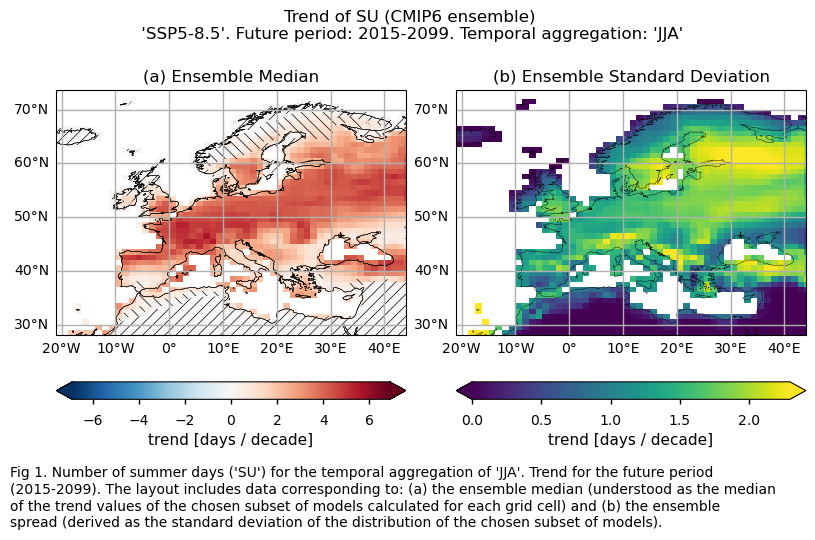

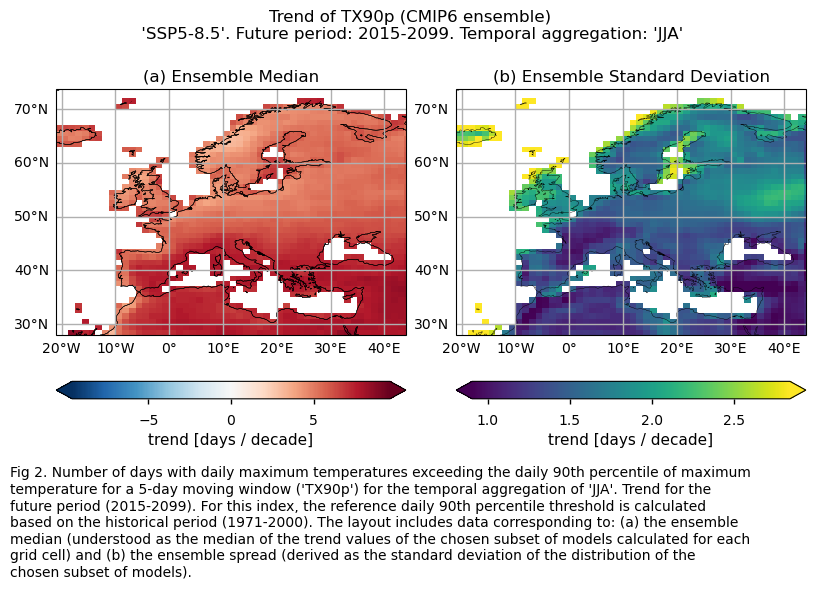

In [11]:
#Change default colorbars
xr.set_options(**cbars)

#Fig number counter
fig_number=1

#Common title
common_title = f"'SSP5-8.5'. Future period: {future_slice.start}-{future_slice.stop}. Temporal aggregation: '{timeseries}'"

for index in index_names:
    # Trend
    da_trend = ds_interpolated["trend"].sel(index=index)
    da_trend.attrs["units"] = f"{ds_interpolated[index].attrs['units']} / decade"
    
    fig = plot_ensemble(
        da_models=da_trend,
        p_value_models=ds_interpolated["p"].sel(index=index),
        center=0,
    )
    fig.suptitle(f"Trend of {index} ({collection_id} ensemble)\n {common_title}",y=0.8)
    add_caption_ensemble(trend=True,exp="future")
    plt.show()
    fig_number=fig_number+1
    print(f"\n")

### 3.3. Plot model maps

In this section, we invoke the `plot_models()` function to visualize the trend over the future period (2015-2099) for every model individually.

Specifically, for each of the indices ('SU' and 'TX90p'), this section presents a single layout including the trend for the future period (2015-2099) of every model.

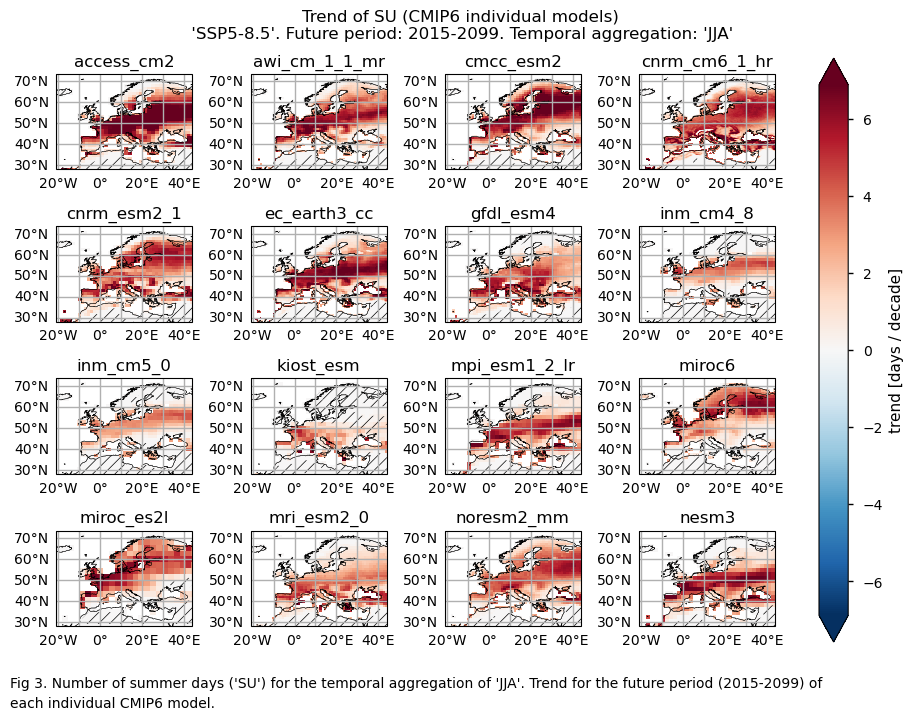

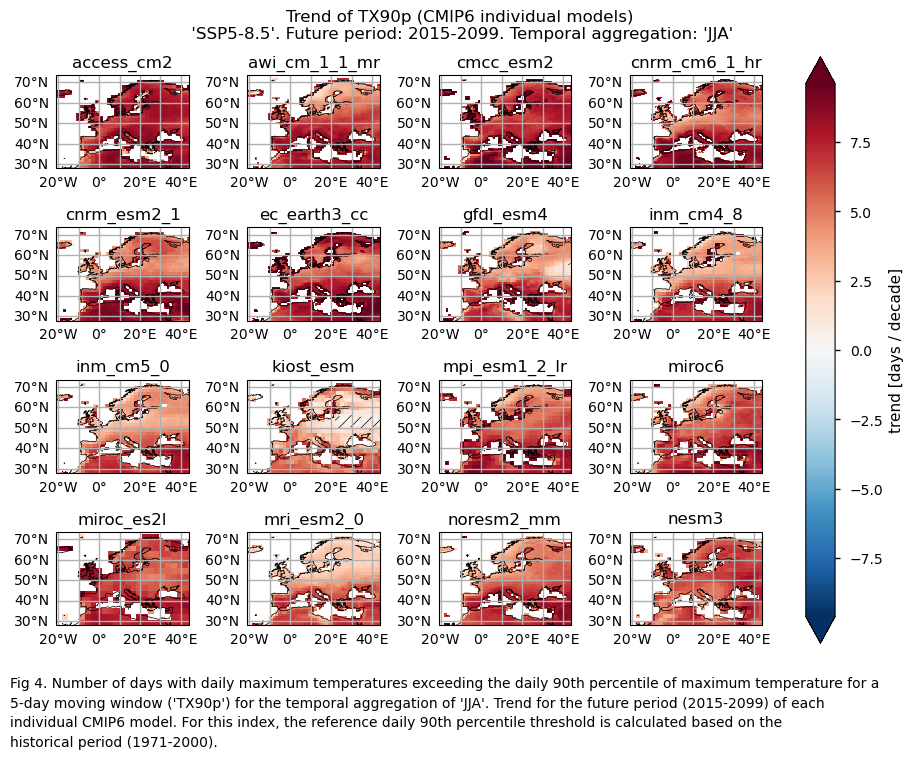

In [12]:
for index in index_names:
   # Trend
    da_for_kwargs_trends = ds_interpolated["trend"].sel(index=index)
    da_for_kwargs_trends.attrs["units"] = f"{ds_interpolated[index].attrs['units']} / decade"
    fig = plot_models(
        data={
            model: ds["trend"].sel(index=index) for model, ds in model_datasets.items()
        },
        da_for_kwargs=da_for_kwargs_trends,
        p_values={
            model: ds["p"].sel(index=index) for model, ds in model_datasets.items()
        },
        figsize=[9,6.5],
        center=0,
    )
    fig.suptitle(f"Trend of {index} ({collection_id} individual models)\n {common_title}")
    add_caption_models(trend=True,exp="future")
    plt.show()
    print(f"\n")
    fig_number=fig_number+1

### 3.4. Boxplots of the future trend

Finally, we present boxplots representing the ensemble distribution of each climate model trend calculated over the future period (2015-2099) across Europe.

Dots represent the spatially-averaged future trend over the selected region (change of the number of days per decade) for each model (grey) and the ensemble mean (blue). The ensemble median is shown as a green line.

The boxplot visually illustrates the distribution of trends (or bias trends) among the climate models, with the box covering the first quartile (Q1 = 25th percentile) to the third quartile (Q3 = 75th percentile), and a green line indicating the ensemble median (Q2 = 50th percentile). Whiskers extend from the edges of the box to show the full data range.

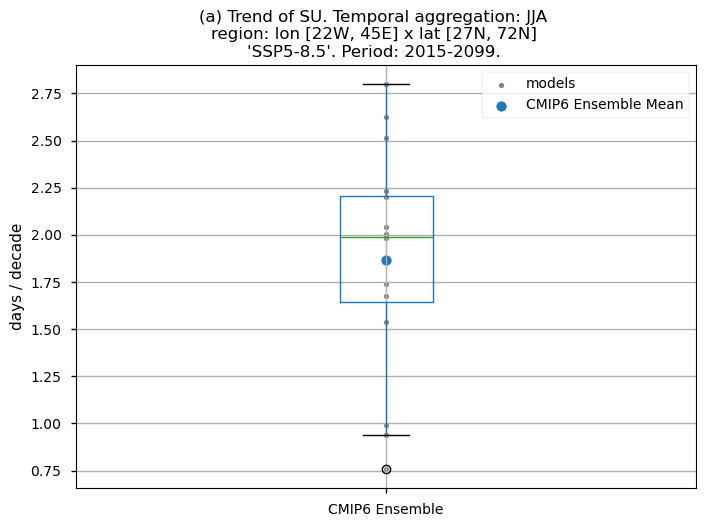

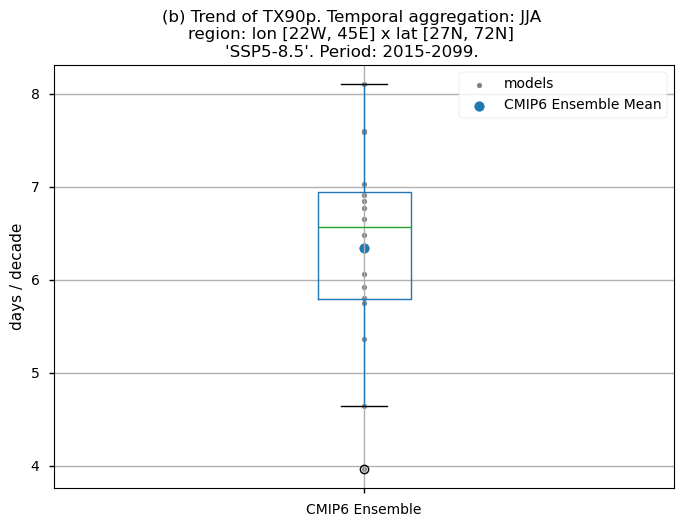

In [13]:
weights = collection_id == "CMIP6"
mean_datasets = [
    diagnostics.spatial_weighted_mean(ds.expand_dims(model=[model]), weights=weights)
    for model, ds in model_datasets.items()
]
mean_ds = xr.concat(mean_datasets, "model",coords='minimal', compat='override')
index_str=1

for index, da in mean_ds["trend"].groupby("index"):
    df_slope = da.to_dataframe()[["trend"]]
    ax = df_slope.boxplot()
    ax.scatter(
        x=[1] * len(df_slope),
        y=df_slope,
        color="grey",
        marker=".",
        label="models",
    )

    # Ensemble mean
    ax.scatter(
        x=1,
        y=da.mean("model"),
        marker="o",
        label=f"{collection_id} Ensemble Mean",
    )

    labels = [f"{collection_id} Ensemble"]
    ax.set_xticks(range(1, len(labels) + 1), labels)
    ax.set_ylabel(f"{ds[index].attrs['units']} / decade")
    plt.suptitle(
            f"({chr(ord('`')+index_str)}) Trend of {index}. Temporal aggregation: {timeseries} \n"
            f"region: lon [{-area[1]}W, {area[3]}E] x lat [{area[2]}N, {area[0]}N] \n"
            f"'SSP5-8.5'. Period: {future_slice.start}-{future_slice.stop}. "
        )  
    plt.legend()
    plt.show()
    index_str=index_str+1

<div>
    <div style="max-width: 800px;">
    <p><strong>Fig 5.</strong> Boxplots illustrating the future trends of the distribution of the chosen subset of models for: (a) the 'SU' index and (b) the 'TX90p' index. The distribution is created by considering spatially averaged trends across Europe. The ensemble mean and the ensemble median trends are both included. Outliers in the distribution are denoted by a grey circle with a black contour.</p>
</div>

### 3.5. Results summary and discussion

- For the temporal aggregation of JJA, future trends (2015-2099) exhibit positive values over Europe for both considered indices. For the number of summer day index (SU), the southern part of the Mediterranean Basin and the northernmost regions of Europe have trends near 0. This may be due to the fact that, for the future period, the number of summer days remains constant near 0 for the northern parts of Europe (where the threshold temperature of 25°C may be too high to be reached). Meanwhile, for the southern part of the Mediterranean Basin, this phenomenon may be attributed to the fact that the threshold is surpassed for the entire JJA season during the whole period of study. This emphasizes the necessity to consider both statistically and physically-based extreme indices for a proper assessment.

- Some regional differences for the 'TX90p' can be seen: higher values for the southern half of Europe. This effect can be better appreciated for the CORDEX analyses.
  
- The boxplots show spatially averaged positive trends over Europe. For the 'SU' index, the ensemble median trends reach a value of 2 days per decade, which is close to the ~2 days per decade obtained for ERA5 during the historical period from 1971 to 2000 for the same index. For the 'TX90p' index, the ensemble median gets a value of around 6.5 days per decade. The interquantile range of the ensemble ranges approximately from 1.7 to 2.25 days per decade for the 'SU' index and from 6 to 7 days per decade for the 'TX90p' index.


## If you want to know more

### Key resources

Some key resources and further reading were linked throughout this assessment.

The CDS catalogue entries for the data used were:
* CMIP6 climate projections: https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cmip6?tab=overview


Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [BOpen](https://www.bopen.eu/)
* [icclim](https://icclim.readthedocs.io/en/stable/) Python package
  
### References
[[1]](https://doi.org/10.3390/atmos11020146) Tesselaar, M., Botzen, W.J.W., Aerts, J.C.J.H. (2020). Impacts of Climate Change and Remote Natural Catastrophes on EU Flood Insurance Markets: An Analysis of Soft and Hard Reinsurance Markets for Flood Coverage. Atmosphere 2020, 11, 146. https://doi.org/10.3390/atmos11020146.

[[2]](https://doi.org/10.5194/nhess-22-659-2022) Rädler, A. T. (2022). Invited perspectives: how does climate change affect the risk of natural hazards? Challenges and step changes from the reinsurance perspective. Nat. Hazards Earth Syst. Sci., 22, 659–664. https://doi.org/10.5194/nhess-22-659-2022.

[[3]](https://www.ipcc.ch/site/assets/uploads/2018/03/wg2TARchap8.pdf) Vellinga, P., Mills, E., Bowers, L., Berz, G.A., Huq, S., Kozak, L.M., Paultikof, J., Schanzenbacker, B., Shida, S., Soler, G., Benson, C., Bidan, P., Bruce, J.W., Huyck, P.M., Lemcke, G., Peara, A., Radevsky, R., Schoubroeck, C.V., Dlugolecki, A.F. (2001). Insurance and other financial services. In J. J. McCarthy, O. F. Canziani, N. A. Leary, D. J. Dokken, & K. S. White (Eds.), Climate change 2001: impacts, adaptation, and vulnerability. Contribution of working group 2 to the third assessment report of the intergovernmental panel on climate change. (pp. 417-450). Cambridge University Press.

[[4]](https://doi.org/10.1002/wcc.71) Lemos, M.C. and Rood, R.B. (2010). Climate projections and their impact on policy and practice. WIREs Clim Chg, 1: 670-682. https://doi.org/10.1002/wcc.71

[[5]](https://doi.org/10.1002/wcc.579) Nissan H, Goddard L, de Perez EC, et al. (2019). On the use and misuse of climate change projections in international development. WIREs Clim Change, 10:e579. https://doi.org/10.1002/wcc.579

[[6]](https://doi.org/10.5194/esd-13-321-2022) Cos, J., Doblas-Reyes, F., Jury, M., Marcos, R., Bretonnière, P.-A., and Samsó, M. (2022). The Mediterranean climate change hotspot in the CMIP5 and CMIP6 projections, Earth Syst. Dynam., 13, 321–340. https://doi.org/10.5194/esd-13-321-2022.
